In [6]:
from tensorboard.backend.event_processing import event_accumulator      
import numpy as np
import pandas as pd
from glob import glob
import sys
import tensorboard.plugins.hparams as hparams
from tensorboard.plugins.hparams import plugin_data_pb2
import tqdm
import re

interesting_keys = ['episode_reward_mean', 'episodes_total', 'custom_metrics/inv_mean_mean', "time_this_iter_s", 'custom_metrics/accept_mean_mean']

def create_df(inpath):
    sg = {event_accumulator.COMPRESSED_HISTOGRAMS: 1,
          event_accumulator.IMAGES: 1,
          event_accumulator.AUDIO: 1,
          event_accumulator.SCALARS: 0,
          event_accumulator.HISTOGRAMS: 1}
    ea = event_accumulator.EventAccumulator(inpath, size_guidance=sg)
    ea.Reload()
    scalar_tags = ea.Tags()['scalars']
    df = pd.DataFrame()
    ids = None
    for tag in interesting_keys:
        fultag = 'ray/tune/' + tag
        
        events = ea.Scalars(fultag)
        if ids is None:
            ids = [x.step for x in events]
            ids_s = set(x.step for x in events)
        scalars = np.array([x.value for x in events if x.step in ids_s])
        df.loc[:, tag] = scalars
    df.loc[:, 'step'] = ids
    return df


In [8]:
fuldfs = []
runid = 0
for path in tqdm.tqdm(glob('logs/megarun/**/*tfevents*', recursive=True)):
    try:
        curdf = create_df(path)
        curdf['run'] = runid
        curdf['badsiteprob'] = float(re.search("good_site_prob=(.+),", path).group(1))
    except Exception as e:
        print(e)
    else:
        fuldfs.append(curdf)
    runid += 1

100%|██████████| 93/93 [04:16<00:00,  2.76s/it]


In [120]:
alldf = pd.concat(fuldfs)

In [123]:
binsize = 500

if 'true_episode_reward_mean' not in alldf.columns:
    alldf['true_episode_reward_mean'] = alldf['episode_reward_mean']
    alldf['episode_reward_mean'] = alldf['true_episode_reward_mean'] / 2
alldf["episode_bin_right"] = alldf["episodes_total"].apply(lambda x: (x // binsize + 1) * binsize )
alldf["step_bin_right"] = alldf["step"].apply(lambda x: (x // binsize + 1) * binsize )

In [124]:
alldf["episode_bin_right"]

0        500.0
1        500.0
2        500.0
3        500.0
4        500.0
        ...   
982    78000.0
983    78500.0
984    78500.0
985    78500.0
986    78500.0
Name: episode_bin_right, Length: 51912, dtype: float64

In [125]:
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set()
sns.set_palette('colorblind')
sns.set_context('talk')

In [128]:
epcollapsed = alldf.groupby(["badsiteprob", "run", "episode_bin_right"], as_index=False).mean()
stepcollapsed = alldf.groupby(["badsiteprob", "run", "step_bin_right"], as_index=False).mean()

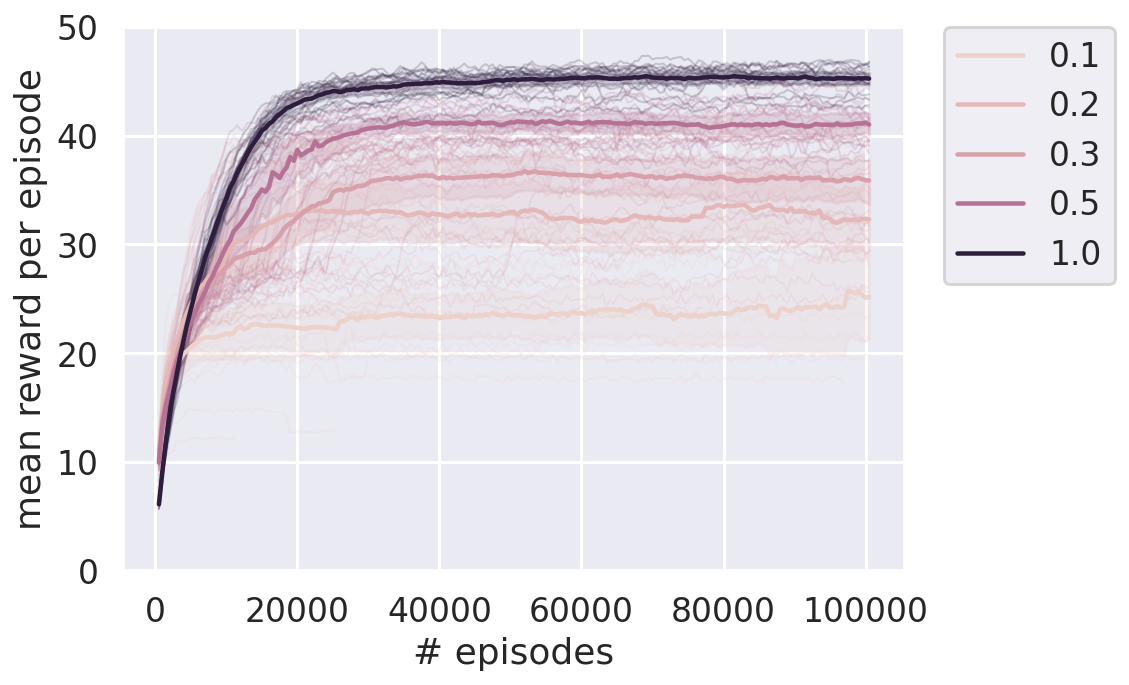

In [129]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="badsiteprob",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='episode_reward_mean', hue="badsiteprob", ax=ax)


plt.ylim(0, 50)
plt.ylabel('mean reward per episode')
plt.xlabel('# episodes')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

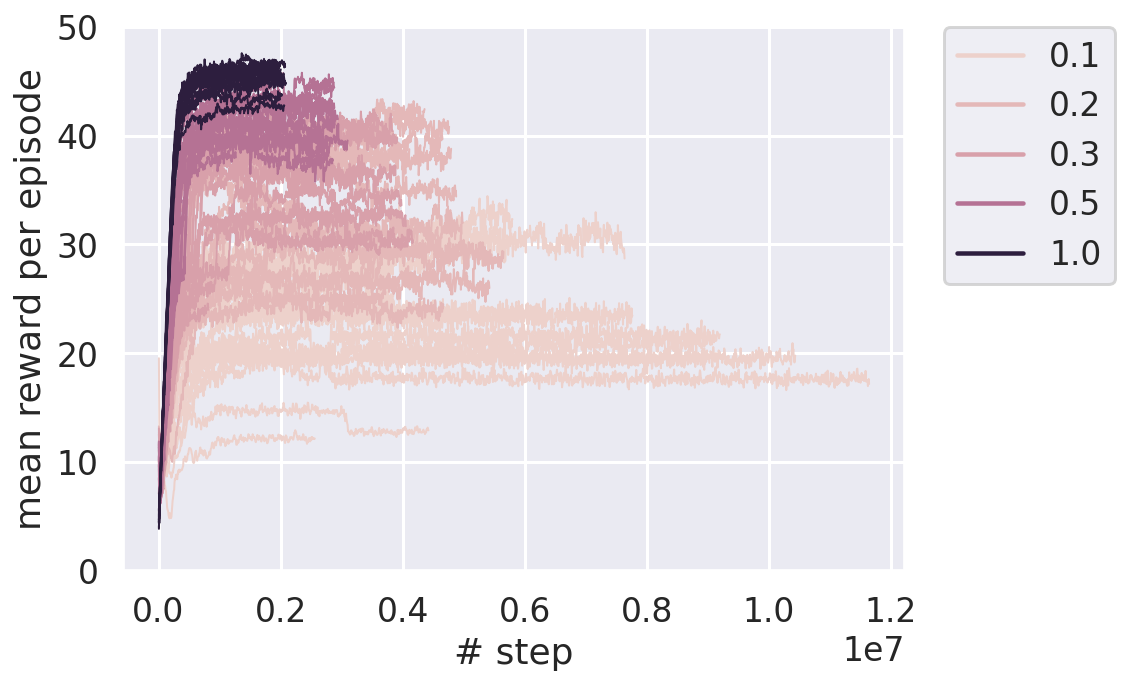

In [135]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
sns.lineplot(
        data=stepcollapsed, x="step_bin_right", y='episode_reward_mean', hue="badsiteprob",
        estimator=None, linewidth=1, ax=ax, units="run"
    )


plt.ylim(0, 50)
plt.ylabel('mean reward per episode')
plt.xlabel('# step')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

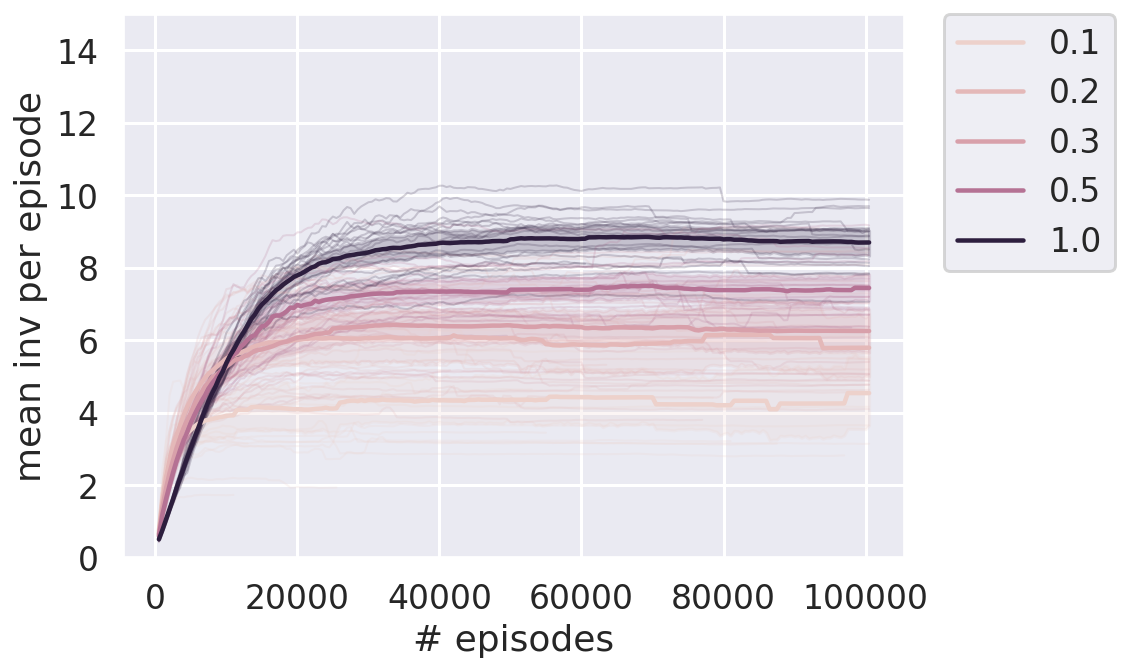

In [132]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv_mean_mean', hue="badsiteprob",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/inv_mean_mean', hue="badsiteprob", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean inv per episode')
plt.xlabel('# episodes')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

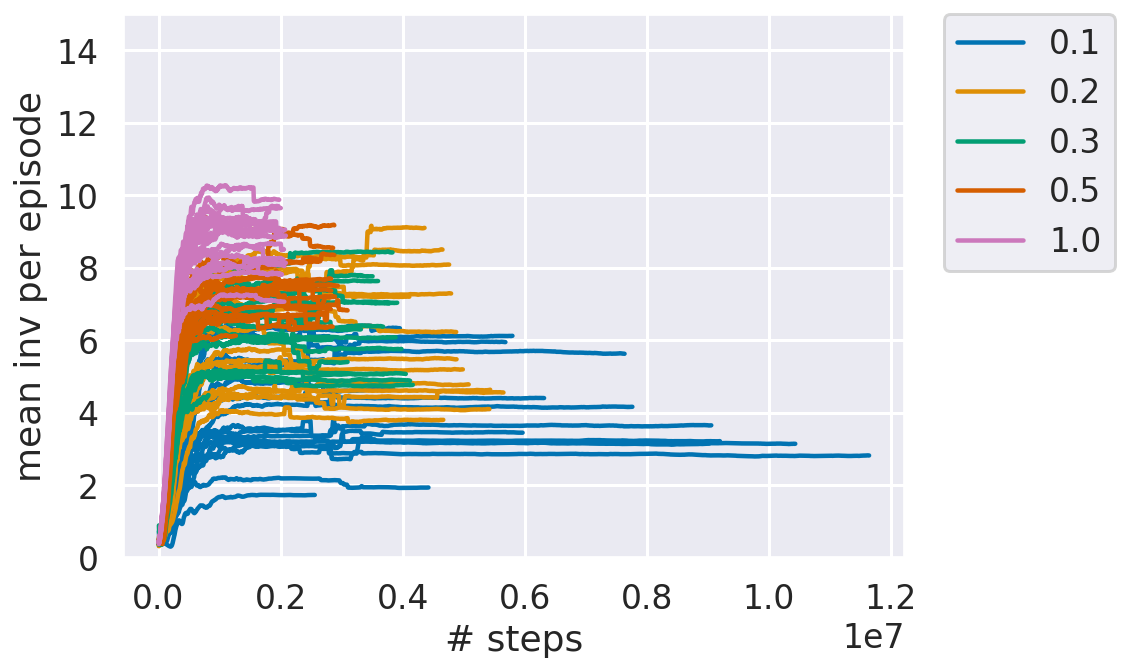

In [15]:
plt.figure(figsize=(7, 5))

sns.lineplot(data=alldf, x="step", y='custom_metrics/inv_mean_mean', hue="badsiteprob", units="run", estimator=None)
plt.ylim(0, 15)
plt.ylabel('mean inv per episode')
plt.xlabel('# steps')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

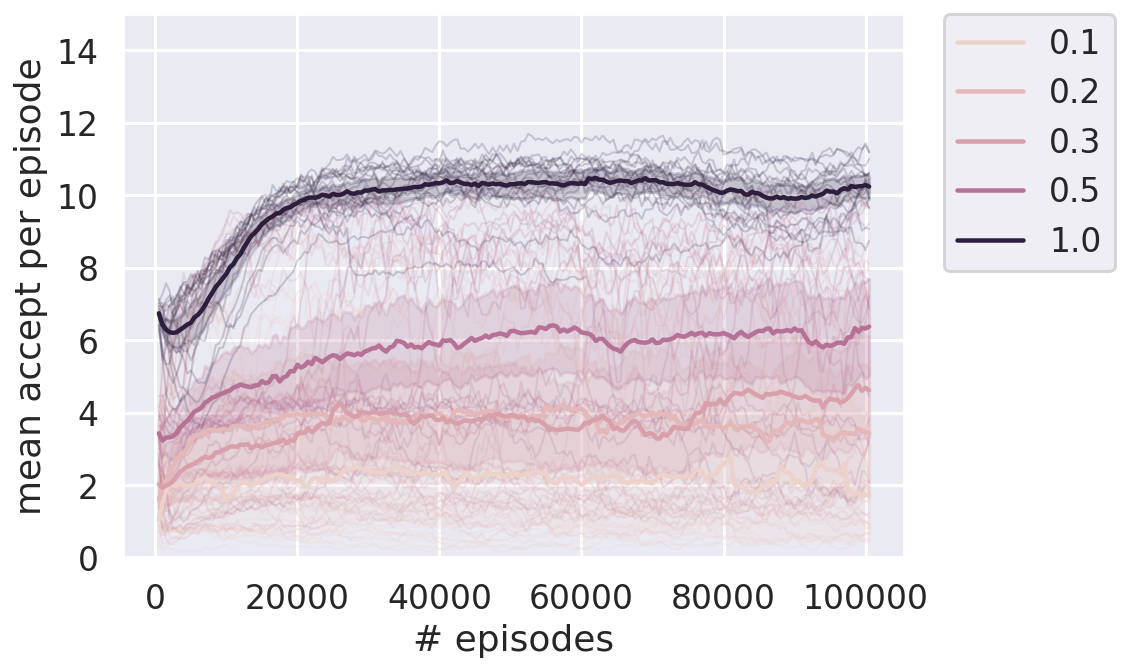

In [133]:
fig = plt.figure(figsize=(7, 5))
ax = fig.gca()
sns.lineplot(
        data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept_mean_mean', hue="badsiteprob",
        estimator=None, alpha=0.2, linewidth=1, ax=ax, units="run", legend=False
    )

sns.lineplot(data=epcollapsed, x="episode_bin_right", y='custom_metrics/accept_mean_mean', hue="badsiteprob", ax=ax)


plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# episodes')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

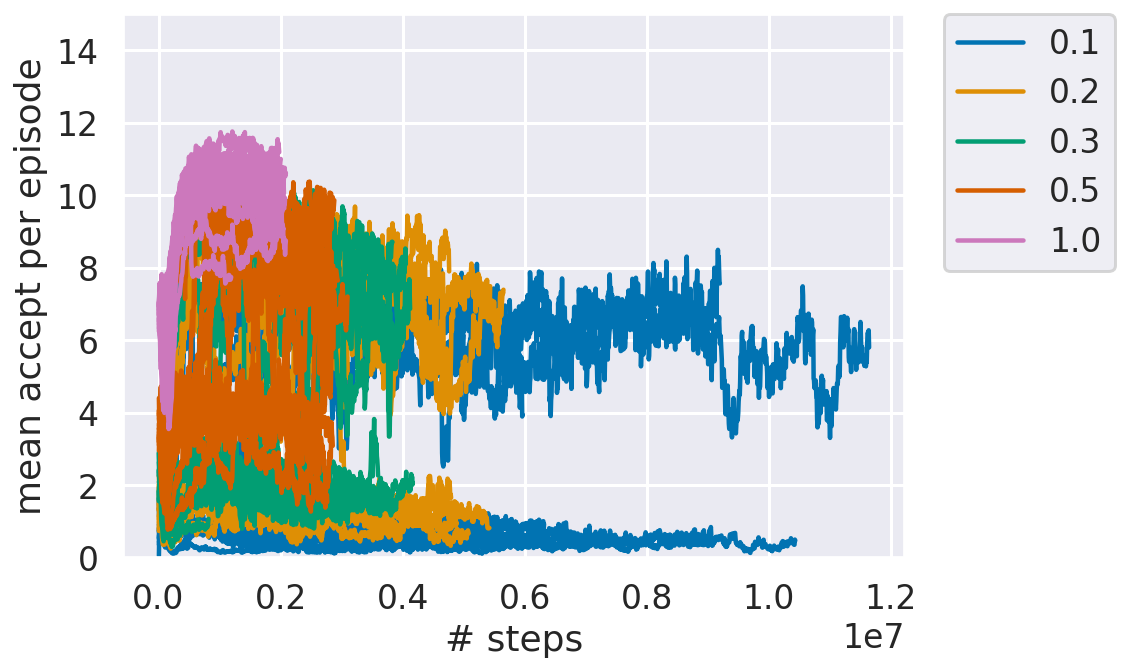

In [17]:
plt.figure(figsize=(7, 5))

sns.lineplot(data=alldf, x="step", y='custom_metrics/accept_mean_mean', hue="badsiteprob", units="run", estimator=None)
plt.ylim(0, 15)
plt.ylabel('mean accept per episode')
plt.xlabel('# steps')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)